<a href="https://colab.research.google.com/github/vicmcl/deeplearwing/blob/main/deeplearwing/notebook/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import glob

In [3]:
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive')
DRIVE_PATH = Path("/content/drive/MyDrive/")
ML_PATH = DRIVE_PATH / "Projects" / "deeplearwing"

Mounted at /content/drive


In [4]:
!git clone https://github.com/vicmcl/deeplearwing.git

fatal: destination path 'deeplearwing' already exists and is not an empty directory.


In [5]:
DATASET = "victorienmichel/deeplearwing"
CONTENT_PATH = Path('/content')
PROJECT_PATH = CONTENT_PATH / 'deeplearwing'
DATA_PATH = PROJECT_PATH / 'data'
ZIP_FILE = DATASET.split('/')[-1].lower() + '.zip'

In [6]:
!cd {PROJECT_PATH} && git pull origin main
!cp -r {PROJECT_PATH / 'deeplearwing' / 'src'} {CONTENT_PATH}

From https://github.com/vicmcl/deeplearwing
 * branch            main       -> FETCH_HEAD
Already up to date.


In [7]:
if not os.path.exists(DATA_PATH):
    print(f'Creating {DATA_PATH}')
    os.makedirs(DATA_PATH)

if not glob.glob(str(DATA_PATH / '*.csv')):

    if not os.path.exists(PROJECT_PATH / ZIP_FILE):
        !kaggle datasets download -d {DATASET} -p {DATA_PATH}

    !unzip {DATA_PATH / ZIP_FILE} -d {DATA_PATH}
    !rm {DATA_PATH / ZIP_FILE}

In [8]:
!pip install -q aerosandbox

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from src.features import string_to_floats
from src.plot import airfoil_to_image
from src.curvature_heatmap import compute_curvature
from src.checkpoint import checkpoint

In [10]:
df_csv = pd.read_csv(DATA_PATH / 'DeepLearWing.csv')
df_csv.head()

,name,angle,reynolds,x_coords,y_coords,cd,cl,cm
0,2032c,-8.75,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.09761,-0.1581,-0.0262
1,2032c,-8.50,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.09468,-0.1536,-0.0262
2,2032c,-8.25,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.10671,-0.2407,-0.0219
3,2032c,-8.00,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.10247,-0.2303,-0.0213
4,2032c,-7.75,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.09947,-0.2229,-0.0215


In [60]:
n_samples = 10_000
df = df_csv.sample(n = n_samples, random_state = 42).copy()

mms_params = MinMaxScaler()
mms_target = MinMaxScaler()

df.loc[:, ['angle', 'reynolds']] = mms_params.fit_transform(df[['angle', 'reynolds']])

targets = ['cd', 'cl', 'cm']
df.loc[:, targets] = mms_target.fit_transform(df[targets])
df['target'] = df.apply(lambda row: [row[t] for t in targets], axis = 1)

df.loc[:, ['x_coords', 'y_coords']] = df[['x_coords', 'y_coords']].applymap(string_to_floats)

df = df.drop(columns = targets)

In [12]:
df.head()

,name,angle,reynolds,x_coords,y_coords,target
51063,fx84w127,0.823899,0.157895,"[1.0, 0.99893, 0.99572, 0.99039, 0.98296, 0.97...","[0.0, 0.00011, 0.0005, 0.0012, 0.0023, 0.00385...","[0.16410609714088875, 0.760406247595599, 0.437..."
802509,s8052,0.308176,0.052632,"[1.0, 0.99803, 0.99231, 0.98301, 0.97022, 0.95...","[0.0, 0.00018, 0.00079, 0.00181, 0.0033, 0.005...","[0.16927316569066483, 0.28383473109179047, 0.4..."
419227,goe505,0.301887,0.000000,"[1.0, 0.94959, 0.89918, 0.7985, 0.69791, 0.597...","[0.0, 0.01784, 0.03568, 0.06537, 0.09105, 0.10...","[0.4231140199793318, 0.34741350568079815, 0.46..."
132195,npl9660,0.735849,0.157895,"[1.0, 0.997614, 0.990418, 0.9785, 0.961985, 0....","[0.0013, 0.001763, 0.002031, 0.002194, 0.00332...","[0.07240785394419566, 0.7069067220640661, 0.49..."
542560,fx78k161,0.213836,0.473684,"[1.0, 0.99893, 0.99572, 0.99039, 0.98296, 0.97...","[0.0, 0.00103, 0.00172, 0.00262, 0.00365, 0.00...","[0.09951774026868758, 0.2525967530968685, 0.35..."


In [61]:
import concurrent.futures

w = 300
h = 100

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures_shape = [executor.submit(airfoil_to_image, row['x_coords'], row['y_coords'], w, h) for _, row in df.iterrows()]
    results_shape = [future.result() for future in futures_shape]

In [91]:
from cv2 import GaussianBlur

df['shape'] = [GaussianBlur(x, (5, 5), 0) for x in results_shape]

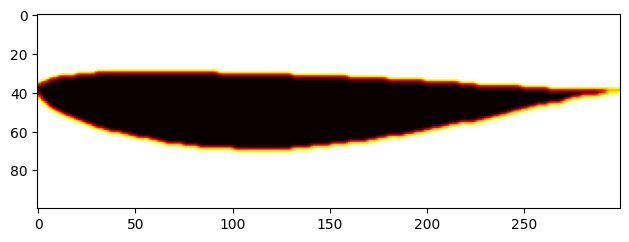

In [87]:
plt.imshow(df['shape'].iloc[0], cmap = 'hot')
plt.tight_layout()
plt.show()

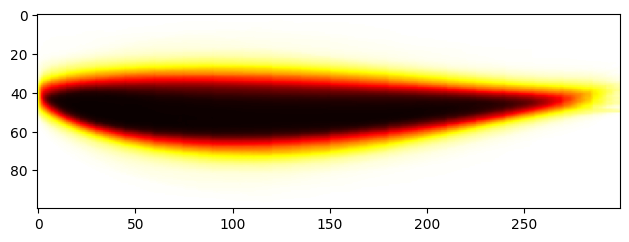

In [89]:
avg_airfoil = np.mean(results_shape, axis = 0)
plt.imshow(avg_airfoil, cmap='hot')
plt.tight_layout()

In [63]:
df['params'] = [x for x in np.column_stack((df['angle'], df['reynolds']))]

In [64]:
features = ['params', 'shape']

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df['target'],
    test_size = 0.2,
    random_state = 42,
    shuffle = True
)

In [98]:
images_train = np.expand_dims(np.array([x for x in X_train['shape']], dtype='float32'), axis = -1)
images_test = np.expand_dims(np.array([x for x in X_test['shape']], dtype='float32'), axis = -1)

params_train = np.array([x for x in X_train['params']], dtype='float32')
params_test = np.array([x for x in X_test['params']], dtype='float32')

y_train = np.array([x for x in y_train])
y_test = np.array([x for x in y_test])

In [99]:
images_train.shape, images_test.shape, params_train.shape, params_test.shape, y_train.shape, y_test.shape

((8000, 100, 300, 1),
 (2000, 100, 300, 1),
 (8000, 2),
 (2000, 2),
 (8000, 3),
 (2000, 3))

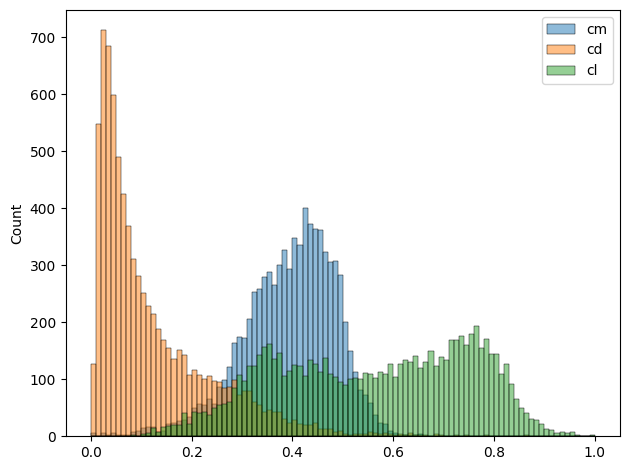

In [29]:
import seaborn as sns

sns.histplot(y_train[:, 2], label = 'cm', bins=100, alpha=0.5)
sns.histplot(y_train[:, 0], label = 'cd', bins=100, alpha=0.5)
sns.histplot(y_train[:, 1], label = 'cl', bins=100, alpha=0.5)
plt.legend()
plt.tight_layout()

In [93]:
from tensorflow.random import set_seed

from tensorflow.keras import backend, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    ReLU,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
    Concatenate,
)

In [94]:
pip install -q keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00


In [95]:
def build_model(hp, channels):

    normalization_conv = hp.Choice("Normalization_conv", ["yes", "no"])
    normalization_dense = hp.Choice("Normalization_dense", ["yes", "no"])

    dropout_conv = hp.Choice("dropout_conv", ["yes", "no"])
    dropout_dense = hp.Choice("dropout_dense", ["yes", "no"])

    rate_dropout_conv = hp.Float(
        "rate_dropout_conv", 0.1, 0.3, step = 0.1, default = 0.3
    )
    rate_dropout_dense = hp.Float(
        "rate_dropout_dense", 0.1, 0.3, step = 0.1, default = 0.3
    )

    # CNN branch
    cnn_input = Input(shape=(h, w, channels))
    x = cnn_input

    for i in range(hp.Int("conv_layers", 2, 4)):
        x = Conv2D(
            filters=hp.Int(
                "filters_" + str(i),
                32,
                128,
                sampling = 'log',
                step = 2,
            ),
            kernel_size=hp.Int("kernel_size_" + str(i), 2, 4, step = 1),
            activation="relu",
            padding="same"
        )(x)

        x = MaxPooling2D()(x)

        if dropout_conv == "yes":
            x = Dropout(rate = rate_dropout_conv)(x)

        if normalization_conv == "yes":
            x = BatchNormalization()(x)

    cnn_output = Flatten()(x)

    # ANN branch
    ann_input = Input(shape=(2,))
    y = ann_input

    for i in range(hp.Int("dense_layers", 2, 4)):
        ann_output = Dense(
            units = hp.Int(
                "ann_neurons_" + str(i),
                32,
                128,
                sampling = 'log',
                step = 2,
            ),
            activation = "relu",
        )(y)

    # Combine the outputs
    combined_inputs = Concatenate()([cnn_output, ann_output])

    for i in range(hp.Int("combined_dense_layers", 2, 4)):
        combined_output = Dense(
            units = hp.Int(
                "combined_neurons_" + str(i),
                32,
                128,
                sampling = 'log',
                step = 2,
            ),
            activation = "relu",
        )(combined_inputs)

        if dropout_dense == "yes":
            x = Dropout(rate=rate_dropout_dense)(x)

        if normalization_dense == "yes":
            x = BatchNormalization()(x)

    combined_output = Dense(units=3)(combined_output)

    # Create the model
    combined_model = Model(
        inputs = [cnn_input, ann_input],
        outputs = combined_output,
        name = "Combined_model"
    )


    # Compile the model
    combined_model.compile(
        loss="mse",
        optimizer=Adam(learning_rate=0.0005),
        metrics=['mae']
    )

    return combined_model

In [100]:
import keras_tuner as kt

tuner = kt.Hyperband(
    hypermodel = lambda hp: build_model(hp, channels=1),
    objective = "val_loss",
    max_epochs = 10,
    hyperband_iterations = 2,
    directory = PROJECT_PATH,
    project_name = "tuner",
    overwrite = True
)

tuner.search(
    [images_train, params_train],
    y_train,
    epochs = 10,
    batch_size = 32,
    shuffle = True,
    validation_split = 0.2,
)

best_model = tuner.get_best_models()[0]
best_model.summary()
best_model.save(ML_PATH / "best_model_shape.keras")

Trial 60 Complete [00h 02m 12s]
val_loss: 0.01835777796804905

Best val_loss So Far: 0.003242496633902192
Total elapsed time: 00h 57m 55s
Model: "Combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 300, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 100, 300, 128)        640       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 50, 150, 128)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                              

In [101]:
best_model = load_model(ML_PATH / "best_model_shape.keras")
best_model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=0.0005),
    metrics=['mae']
)

history = best_model.fit(
    [images_train, params_train],
    y_train,
    epochs = 100,
    batch_size = 32,
    callbacks=checkpoint(ML_PATH / f"weights_tuned_model.h5", patience = 3),
    validation_split = 0.2,
    shuffle = True,
    verbose = 1,
)

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0372

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 19s 85ms/step - loss: 0.0027 - mae: 0.0372 - val_loss: 0.0031 - val_mae: 0.0382
Epoch 2/100
200/200 [==============================] - 15s 73ms/step - loss: 0.0025 - mae: 0.0358 - val_loss: 0.0029 - val_mae: 0.0372
Epoch 3/100
200/200 [==============================] - 14s 71ms/step - loss: 0.0023 - mae: 0.0347 - val_loss: 0.0030 - val_mae: 0.0386
Epoch 4/100
200/200 [==============================] - 14s 71ms/step - loss: 0.0022 - mae: 0.0338 - val_loss: 0.0030 - val_mae: 0.0367
Epoch 5/100
200/200 [==============================] - 14s 71ms/step - loss: 0.0021 - mae: 0.0330 - val_loss: 0.0031 - val_mae: 0.0390


In [102]:
best_model.evaluate([images_test, params_test], y_test)

63/63 [==============================] - 2s 27ms/step - loss: 0.0028 - mae: 0.0385


[0.0028105995152145624, 0.038519810885190964]

In [66]:
from tqdm import tqdm
curvatures = [compute_curvature(img) for img in tqdm(df['shape'])]

100%|██████████| 10000/10000 [01:53<00:00, 87.79it/s]


In [103]:
def image_generator(df, batch_size=32, h=h, w=w):
    num_samples = len(df)
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        batch_df = df.iloc[start:end]

        combined_images = []
        indices = []

        for idx, row in batch_df.iterrows():
            channel1 = np.array(row['shape'], dtype=np.float32)
            channel2 = np.array(row['curvature'], dtype=np.float32)
            combined_image = np.stack([channel1, channel2], axis=-1)
            combined_images.append(combined_image)
            indices.append(idx)

        yield pd.DataFrame({'combined_image': combined_images}, index=indices)

In [104]:
images_2_channels = pd.DataFrame()
for batch in image_generator(df):
    images_2_channels = pd.concat([images_2_channels, batch])

In [105]:
df = pd.concat([df, images_2_channels], axis=1)

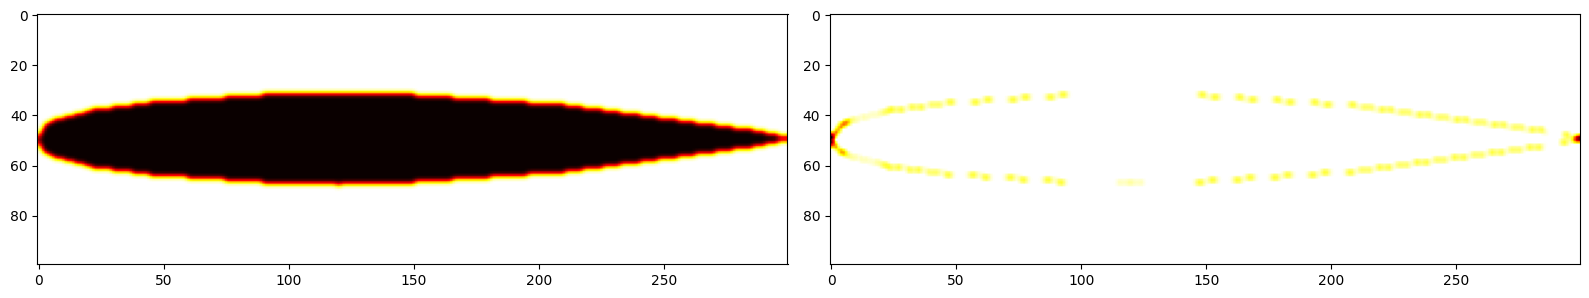

In [106]:
n = 150
fig = plt.figure(figsize = (16, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(df['shape'].iloc[n], cmap = 'hot')
fig.add_subplot(1, 2, 2)
plt.imshow(curvatures[n], cmap = 'hot_r')
plt.tight_layout()

In [107]:
features = ['combined_image', 'params']

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df['target'],
    test_size = 0.2,
    random_state = 42,
    shuffle = True
)

In [111]:
images_train = np.array([x for x in X_train['combined_image']], dtype='float32')
images_test = np.array([x for x in X_test['combined_image']], dtype='float32')

params_train = np.array([x for x in X_train['params']], dtype='float32')
params_test = np.array([x for x in X_test['params']], dtype='float32')

y_train = np.array([x for x in y_train])
y_test = np.array([x for x in y_test])

In [112]:
images_train.shape, images_test.shape, params_train.shape, params_test.shape, y_train.shape, y_test.shape

((8000, 100, 300, 2),
 (2000, 100, 300, 2),
 (8000, 2),
 (2000, 2),
 (8000, 3),
 (2000, 3))

In [113]:
tuner = kt.Hyperband(
    hypermodel = lambda hp: build_model(hp, channels=2),
    objective = "val_loss",
    max_epochs = 10,
    hyperband_iterations = 2,
    directory = PROJECT_PATH,
    project_name = "tuner",
    overwrite = True
)

tuner.search(
    [images_train, params_train],
    y_train,
    epochs = 10,
    batch_size = 32,
    shuffle = True,
    validation_split = 0.2,
)

best_model = tuner.get_best_models()[0]
best_model.summary()
best_model.save(ML_PATH / "best_model_curvature.keras")

Trial 60 Complete [00h 02m 02s]
val_loss: 0.0035377047024667263

Best val_loss So Far: 0.003119562054052949
Total elapsed time: 01h 00m 01s
Model: "Combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 300, 2)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 100, 300, 32)         1056      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 50, 150, 32)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                            

In [114]:
best_model = load_model(ML_PATH / "best_model_curvature.keras")
best_model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=0.0005),
    metrics=['mae']
)

history = best_model.fit(
    [images_train, params_train],
    y_train,
    epochs = 100,
    batch_size = 32,
    callbacks=checkpoint(ML_PATH / f"weights_tuned_model.h5", patience = 3),
    validation_split = 0.2,
    shuffle = True,
    verbose = 1,
)

Epoch 1/100
199/200 [============================>.] - ETA: 0s - loss: 0.0025 - mae: 0.0357

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 8s 33ms/step - loss: 0.0025 - mae: 0.0357 - val_loss: 0.0031 - val_mae: 0.0370
Epoch 2/100
200/200 [==============================] - 6s 28ms/step - loss: 0.0022 - mae: 0.0339 - val_loss: 0.0031 - val_mae: 0.0370
Epoch 3/100
200/200 [==============================] - 6s 28ms/step - loss: 0.0020 - mae: 0.0324 - val_loss: 0.0032 - val_mae: 0.0386
Epoch 4/100
200/200 [==============================] - 6s 31ms/step - loss: 0.0020 - mae: 0.0326 - val_loss: 0.0030 - val_mae: 0.0373
Epoch 5/100
200/200 [==============================] - 6s 29ms/step - loss: 0.0017 - mae: 0.0298 - val_loss: 0.0028 - val_mae: 0.0349
Epoch 6/100
200/200 [==============================] - 6s 28ms/step - loss: 0.0016 - mae: 0.0291 - val_loss: 0.0029 - val_mae: 0.0356
Epoch 7/100
200/200 [==============================] - 6s 32ms/step - loss: 0.0015 - mae: 0.0281 - val_loss: 0.0028 - val_mae: 0.0350
Epoch 8/100
200/200 [==============================] - 6s 29ms/step - loss

In [115]:
best_model.evaluate([images_test, params_test], y_test)

63/63 [==============================] - 1s 13ms/step - loss: 0.0024 - mae: 0.0328


[0.002358474535867572, 0.03284493461251259]